In [1]:
import numpy as np
import pandas as pd

iris = pd.read_csv('../data/iris_tts.csv')
iris.head()

,TD_IsTrainRow,serial_num,target_cat,target_num,sepal_length,sepal_width,petal_length,petal_width
0,1,149,virginica,2,6.2,3.4,5.4,2.3
1,0,10,setosa,0,4.9,3.1,1.5,0.1
2,1,36,setosa,0,5.0,3.2,1.2,0.2
3,0,17,setosa,0,5.4,3.9,1.3,0.4
4,1,83,versicolor,1,5.8,2.7,3.9,1.2


In [2]:
# 学習と検証用に使用するデータのみを抽出する
iris_train = iris.loc[iris['TD_IsTrainRow']==1, :]
iris_train.head()

,TD_IsTrainRow,serial_num,target_cat,target_num,sepal_length,sepal_width,petal_length,petal_width
0,1,149,virginica,2,6.2,3.4,5.4,2.3
2,1,36,setosa,0,5.0,3.2,1.2,0.2
4,1,83,versicolor,1,5.8,2.7,3.9,1.2
6,1,117,virginica,2,6.5,3.0,5.5,1.8
8,1,98,versicolor,1,6.2,2.9,4.3,1.3


In [3]:
iris_train.shape

(135, 8)

In [4]:
X = iris_train.iloc[:, 4:]
y = iris_train.iloc[:, 3]
X.shape, y.shape

((135, 4), (135,))

In [5]:
# early_stopping用の評価データを分割
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((101, 4), (34, 4), (101,), (34,))

In [6]:
X_train.head()

,sepal_length,sepal_width,petal_length,petal_width
83,5.4,3.9,1.7,0.4
71,4.6,3.6,1.0,0.2
39,6.6,3.0,4.4,1.4
128,5.7,3.0,4.2,1.2
133,4.4,2.9,1.4,0.2


In [7]:
X_valid.head()

,sepal_length,sepal_width,petal_length,petal_width
113,5.1,3.5,1.4,0.2
82,5.1,3.3,1.7,0.5
120,6.3,2.3,4.4,1.3
34,6.1,2.9,4.7,1.4
57,4.6,3.2,1.4,0.2


In [8]:
y_train

83     0
71     0
39     1
128    1
133    0
      ..
86     1
121    2
28     0
107    0
117    0
Name: target_num, Length: 101, dtype: int64

In [9]:
y_valid

113    0
82     0
120    1
34     1
57     0
77     2
24     0
125    0
140    2
143    1
59     2
55     0
42     1
115    1
134    1
46     1
66     1
8      1
99     1
96     0
100    2
41     0
31     2
33     2
20     1
126    1
60     1
22     1
138    1
95     1
119    1
98     2
51     0
0      2
Name: target_num, dtype: int64

In [10]:
# LightGBMモデルの実装
# PMML形式でモデルを出力したいため、scikit-learn APIを使用する
import lightgbm as lgb

# 使用するパラメータ
params = {'objective': 'multiclass',  # 最小化させるべき損失関数
         'random_state': 42,  # 乱数シード
         'boosting_type': 'gbdt',  # boosting_type
         'n_estimators': 10000  # 最大学習サイクル数。early_stopping使用時は大きな値を入力
         }

# early_stoppingを指定してLightGBM学習
lgbc = lgb.LGBMClassifier(**params)

lgbc.fit(X_train, y_train,
         eval_metric='logloss', # early_stoppingの評価指標(学習用の'metric'パラメータにも同じ指標が自動入力される)
         eval_set=[(X_valid, y_valid)],
         callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=True), # early_stopping用コールバック関数
                    lgb.log_evaluation(1)] # コマンドライン出力用コールバック関数
        )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 101, number of used features: 4
[LightGBM] [Info] Start training from score -1.031602
[LightGBM] [Info] Start training from score -1.282916
[LightGBM] [Info] Start training from score -1.004203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 0.983937
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2

LGBMClassifier(n_estimators=10000, objective='multiclass', random_state=42)

In [11]:
# Boosterオブジェクトを取得
booster = lgbc.booster_
booster

In [12]:
# 特徴量の重要度を取得
importance = booster.feature_importance(importance_type='split')
print(importance)

[ 24  20  90 105]


In [13]:
y_pred = lgbc.predict(X_valid)
y_pred

array([0, 0, 1, 1, 0, 2, 0, 0, 2, 1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 0,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2])

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred)

array([[ 9,  0,  0],
       [ 0, 16,  1],
       [ 0,  0,  8]])

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.94      0.97        17
           2       0.89      1.00      0.94         8

    accuracy                           0.97        34
   macro avg       0.96      0.98      0.97        34
weighted avg       0.97      0.97      0.97        34



In [16]:
# PMMLでモデルを保存する前提のコード
from sklearn.pipeline import Pipeline
import lightgbm as lgb

# 使用するパラメータ
params = {'objective': 'multiclass',  # 最小化させるべき損失関数
         'random_state': 42,  # 乱数シード
         'boosting_type': 'gbdt',  # boosting_type
         'n_estimators': 10000  # 最大学習サイクル数。early_stopping使用時は大きな値を入力
         }


pipeline_obj = Pipeline([
    ('lgbmc',lgb.LGBMClassifier(**params))
])

In [17]:
pipeline_obj.fit(X_train, y_train,
                 lgbmc__eval_metric='logloss', # early_stoppingの評価指標(学習用の'metric'パラメータにも同じ指標が自動入力される)
                 lgbmc__eval_set=[(X_valid, y_valid)],
                 lgbmc__callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=True), # early_stopping用コールバック関数
                                   lgb.log_evaluation(1)] # コマンドライン出力用コールバック関数
                )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 101, number of used features: 4
[LightGBM] [Info] Start training from score -1.031602
[LightGBM] [Info] Start training from score -1.282916
[LightGBM] [Info] Start training from score -1.004203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 0.983937
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2

Pipeline(steps=[('lgbmc',
                 LGBMClassifier(n_estimators=10000, objective='multiclass',
                                random_state=42))])

In [18]:
booster = pipeline_obj["lgbmc"].booster_
booster

In [37]:
# 特徴量の重要度を取得
importance = booster.feature_importance(importance_type='split')
print(importance)

[ 24  20  90 105]


In [33]:
# 特徴量の重要度を取得
importance = pipeline_obj['lgbmc'].feature_importances_
importance

array([ 24,  20,  90, 105], dtype=int32)

In [35]:
booster.feature_name()

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [41]:
fi_dict = {fname:fivalue for fname, fivalue in zip(booster.feature_name(), booster.feature_importance(importance_type='split'))}
fi_dict

{'sepal_length': 24, 'sepal_width': 20, 'petal_length': 90, 'petal_width': 105}

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

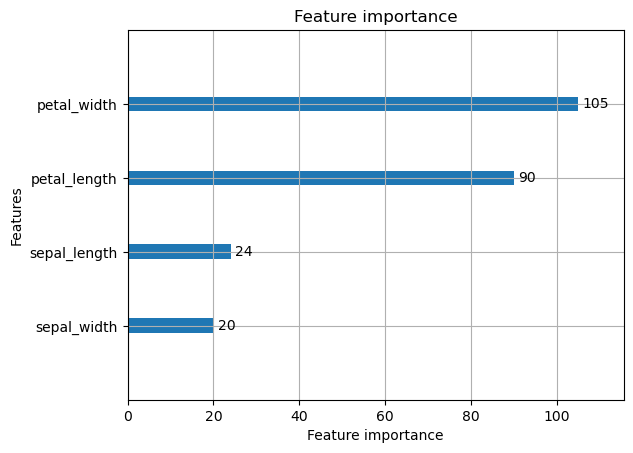

In [21]:
lgb.plot_importance(pipeline_obj["lgbmc"].booster_)

In [22]:
pipeline_obj["lgbmc"].booster_

In [23]:
y_pred = lgbc.predict(X_valid)
y_pred

array([0, 0, 1, 1, 0, 2, 0, 0, 2, 1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 0,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2])

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred)

array([[ 9,  0,  0],
       [ 0, 16,  1],
       [ 0,  0,  8]])

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.94      0.97        17
           2       0.89      1.00      0.94         8

    accuracy                           0.97        34
   macro avg       0.96      0.98      0.97        34
weighted avg       0.97      0.97      0.97        34



In [26]:
import nyoka
nyoka.__version__

'5.5.0'

In [27]:
X.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')

In [28]:
from nyoka import lgb_to_pmml

# 説明変数と目的変数の名前を指定する必要がある
features = X.columns
target = 'target'

lgb_to_pmml(pipeline_obj, features, target, "iris_lgbmc.pmml")

In [29]:
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

model = Pipeline([('scaler', MinMaxScaler()),
                  ('xgb', XGBClassifier())
                 ]
                )

model.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

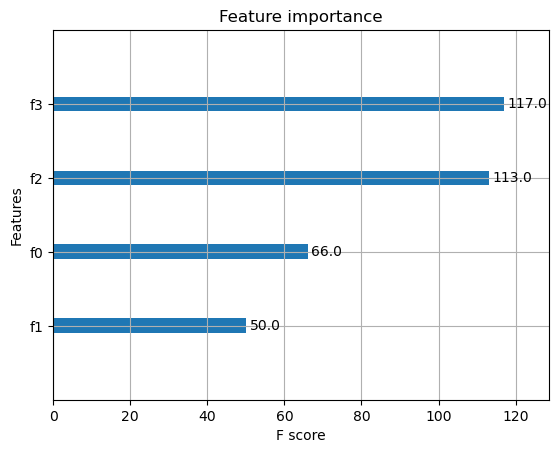

In [30]:
from xgboost import plot_importance
plot_importance(model["xgb"].get_booster(), max_num_features=10)

In [31]:
feature_importance = model["xgb"].get_booster().get_score(importance_type="weight")
feature_importance

{'f0': 66.0, 'f1': 50.0, 'f2': 113.0, 'f3': 117.0}

In [32]:
type(feature_importance)

dict